In [57]:
import pandas as pd
import matplotlib
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [2]:
# Load CSV files
df = pd.read_csv('D:/Courses/INSY 695/Project Repository/E-commerce_Promotion_Analysis/Datasets/cleaned_trained_data.csv')

#'D:/Courses/INSY 695/Project Repository/E-commerce_Promotion_Analysis/Datasets/cleaned_trained_data.csv'

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Not Specified,No Loan,Mortgage Loan,Student Loan,Debt Consolidation Loan,Payday Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114,1824.843333,3,...,1,1,1,1,0,0,0,0,0,0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114,3093.745000,3,...,1,1,1,1,0,0,0,0,0,0
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114,3093.745000,3,...,1,1,1,1,0,0,0,0,0,0
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114,3093.745000,3,...,1,1,1,1,0,0,0,0,0,0
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114,1824.843333,3,...,1,1,1,1,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  int64  
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  int64  
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  int64  
 13  Type_of_Loan              100000 non-null  ob

#### Extracting numerical, ordinal and one-hot encoding variables to apply relevant preprocessing

In [5]:
# Define column groups based on dataset
num_cols = [
    "Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts",
    "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date",
    "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries",
    "Outstanding_Debt", "Credit_Utilization_Ratio", "Credit_History_Age",
    "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"
]


ordinal_cols = ["Credit_Score", "Payment_of_Min_Amount", "Credit_Mix"]


one_hot_cols = ["Occupation", "Payment_Behaviour"]


target_col = ["Credit_Score"]

In [6]:
# Apply Label Encoding to each column
for col in ordinal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [7]:
# Apply One-Hot Encoding using pandas
df = pd.get_dummies(df, columns=one_hot_cols)

#### Mapping months to number to keep it ordinal

In [8]:
# Dictionary to map month names to numbers
month_mapping = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

# Apply mapping
df["Month_Num"] = df["Month"].map(month_mapping)

#### Scaling the numerical columns

In [11]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols)
])

In [12]:
# Apply transformation
X_transformed = preprocessor.fit_transform(df.drop(columns=target_col))
df_scaled = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())


In [13]:
X = df_scaled.select_dtypes(exclude=['object'])

In [14]:
# Target variable
y = df["Credit_Score"]

#### Trying 3 different feature selection methods: RFE, RF Feature Importances, LassoCV

In [17]:
# Define model
model1 = XGBClassifier(random_state=42)

In [18]:
# Apply Recursive Feature Elimination (RFE)
rfe = RFE(estimator = model1, n_features_to_select=10)
X_selected = rfe.fit_transform(X, y)

In [19]:
# Create DataFrame of feature rankings
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})

# Sort by ranking
feature_ranking = feature_ranking.sort_values(by="Ranking")

# Display rankings
print(feature_ranking)

                          Feature  Ranking
8     num__Num_of_Delayed_Payment        1
14       num__Total_EMI_per_month        1
3          num__Num_Bank_Accounts        1
4            num__Num_Credit_Card        1
5              num__Interest_Rate        1
6                num__Num_of_Loan        1
7        num__Delay_from_due_date        1
9       num__Changed_Credit_Limit        1
10      num__Num_Credit_Inquiries        1
11          num__Outstanding_Debt        1
1              num__Annual_Income        2
13        num__Credit_History_Age        3
0                        num__Age        4
2      num__Monthly_Inhand_Salary        5
15   num__Amount_invested_monthly        6
16           num__Monthly_Balance        7
12  num__Credit_Utilization_Ratio        8


In [20]:
# Define model
model2 = RandomForestClassifier(random_state=42)

In [21]:
# Train a random forest model
model2.fit(X, y)

RandomForestClassifier(random_state=42)

In [22]:
# Get feature importance scores
feature_importances = model2.feature_importances_

# Rank features
feature_ranking = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

In [23]:
# Display top features
print("Feature Importances:")
print(feature_ranking)

Feature Importances:
num__Outstanding_Debt            0.120842
num__Interest_Rate               0.102367
num__Delay_from_due_date         0.071403
num__Credit_Utilization_Ratio    0.061530
num__Monthly_Balance             0.061246
num__Amount_invested_monthly     0.059645
num__Changed_Credit_Limit        0.055162
num__Num_of_Delayed_Payment      0.052338
num__Num_Credit_Card             0.051538
num__Num_Credit_Inquiries        0.051274
num__Annual_Income               0.051078
num__Credit_History_Age          0.048627
num__Age                         0.047588
num__Total_EMI_per_month         0.047474
num__Monthly_Inhand_Salary       0.045472
num__Num_Bank_Accounts           0.042930
num__Num_of_Loan                 0.029485
dtype: float64


In [24]:
# Perform Lasso Feature Selection with Cross-Validation
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(X, y)

LassoCV(cv=5, random_state=42)

In [25]:
# Get the coefficients of the selected features
lasso_coeffs = pd.Series(lasso.coef_, index=X.columns)

# Filter out features with non-zero coefficients (important features)
selected_features = lasso_coeffs[lasso_coeffs != 0].sort_values(ascending=False)

In [26]:
# Display selected features
print(f"Selected Features: {selected_features}")

Selected Features: num__Changed_Credit_Limit       0.140671
num__Num_of_Delayed_Payment     0.119684
num__Num_Bank_Accounts          0.070911
num__Num_Credit_Card            0.042341
num__Interest_Rate              0.026392
num__Monthly_Balance            0.007017
num__Amount_invested_monthly   -0.000361
num__Total_EMI_per_month       -0.003602
num__Annual_Income             -0.004057
num__Monthly_Inhand_Salary     -0.011852
num__Age                       -0.014349
num__Num_of_Loan               -0.017618
num__Credit_History_Age        -0.019324
num__Num_Credit_Inquiries      -0.045425
num__Outstanding_Debt          -0.141040
dtype: float64


In [27]:
# Select features with non-zero coefficients and sort by absolute importance
top_lasso_features = lasso_coeffs.abs().sort_values(ascending=False).head(10)

# Sort and get top 10 important features from Tree-based model
top_tree_features = feature_ranking.sort_values(ascending=False).head(10)

# Get top 10 features from Recursive Feature Elimination (RFE)
top_rfe_features = X.columns[rfe.support_]
top_rfe_features = top_rfe_features[:10]

In [28]:
# Get feature names from both methods
lasso_top_names = top_lasso_features.index.tolist()
tree_top_names = top_tree_features.index.tolist()
rfe_top_names = top_rfe_features.tolist()

In [29]:
# Find common features selected by Lasso, Tree-based Model, and RFE
common_features_all = list(set(lasso_top_names) & set(tree_top_names) & set(rfe_top_names))

In [30]:
# Find features common to any two methods
common_features_lasso_tree = list(set(lasso_top_names) & set(tree_top_names))
common_features_lasso_rfe = list(set(lasso_top_names) & set(rfe_top_names))
common_features_tree_rfe = list(set(tree_top_names) & set(rfe_top_names))

In [31]:
# Print Results
print(f"Common Features Across All Three Methods: {common_features_all}")
print(f"Common Features (Lasso & Tree-based): {common_features_lasso_tree}")
print(f"Common Features (Lasso & RFE): {common_features_lasso_rfe}")
print(f"Common Features (Tree-based & RFE): {common_features_tree_rfe}")

Common Features Across All Three Methods: ['num__Num_of_Delayed_Payment', 'num__Num_Credit_Card', 'num__Num_Credit_Inquiries', 'num__Interest_Rate', 'num__Changed_Credit_Limit', 'num__Outstanding_Debt']
Common Features (Lasso & Tree-based): ['num__Num_of_Delayed_Payment', 'num__Num_Credit_Card', 'num__Num_Credit_Inquiries', 'num__Interest_Rate', 'num__Changed_Credit_Limit', 'num__Outstanding_Debt']
Common Features (Lasso & RFE): ['num__Num_of_Delayed_Payment', 'num__Num_Credit_Card', 'num__Num_of_Loan', 'num__Num_Credit_Inquiries', 'num__Num_Bank_Accounts', 'num__Interest_Rate', 'num__Changed_Credit_Limit', 'num__Outstanding_Debt']
Common Features (Tree-based & RFE): ['num__Num_of_Delayed_Payment', 'num__Num_Credit_Card', 'num__Num_Credit_Inquiries', 'num__Delay_from_due_date', 'num__Interest_Rate', 'num__Changed_Credit_Limit', 'num__Outstanding_Debt']


#### Lets try with all common features first, then we'll play around and see if we can improve our accuracy

In [32]:
# Select the final set of features (either common ones or a union of top features)
final_selected_features = common_features_all

In [33]:
# Create a new dataset with only the selected features
X_selected = X[final_selected_features]

X_selected

,num__Num_of_Delayed_Payment,num__Num_Credit_Card,num__Num_Credit_Inquiries,num__Interest_Rate,num__Changed_Credit_Limit,num__Outstanding_Debt
0,-1.055979,-0.714128,-0.450557,-1.314508,0.159631,-0.533901
1,0.099558,-0.714128,-0.450557,-1.314508,0.159631,-0.533901
2,-1.055979,-0.714128,-0.450557,-1.314508,-0.143128,-0.533901
3,-1.551209,-0.714128,-0.450557,-1.314508,-0.597266,-0.533901
4,0.099558,-0.714128,-0.450557,-1.314508,0.159631,-0.533901
...,...,...,...,...,...,...
99995,-1.055979,0.191965,-0.699885,-0.861053,0.159631,-0.799672
99996,-1.055979,0.191965,-0.699885,-0.861053,0.159631,-0.799672
99997,-1.221056,0.191965,-0.699885,-0.861053,0.159631,-0.799672
99998,0.099558,0.191965,-0.699885,-0.861053,0.159631,-0.799672


#### Testing base models with cross-validation to see which model performs the best

In [48]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


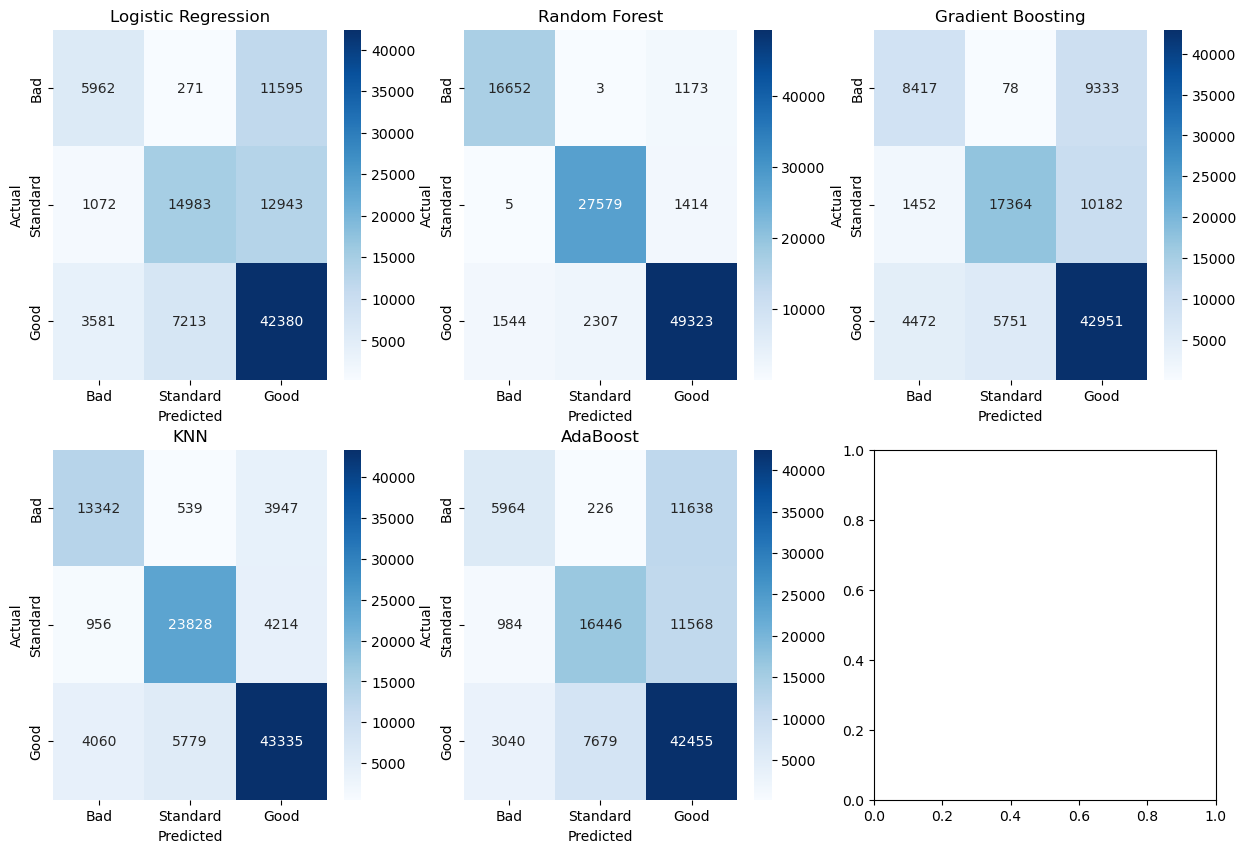

In [49]:
# Set up figure size for multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten() 
# Define class labels 
class_labels = ["Bad", "Standard", "Good"]

# Loop through each model and generate confusion matrix
for i, (name, model) in enumerate(models.items()):
    # Train model
    model.fit(X_selected, y)
    
    # Predict on test set
    y_pred = model.predict(X_selected)
    
    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f"{name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

In [50]:
# Define Stratified K-Fold (Ensures balanced class distribution across folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [51]:
# Dictionary to store cross-validation results
cv_results = {}

In [52]:
# Loop through models and evaluate using cross-validation
for name, model in models.items():
    start_time = time.time()
    
    # Perform 5-fold cross-validation
    scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
    
    # Store mean accuracy and standard deviation
    cv_results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Dev": np.std(scores)
    }
    
    # Print results
    print(f"{name}: Mean Accuracy = {np.mean(scores):.4f} ± {np.std(scores):.4f} (Time: {time.time() - start_time:.2f}s)")

Logistic Regression: Mean Accuracy = 0.6332 ± 0.0034 (Time: 0.35s)
Random Forest: Mean Accuracy = 0.7644 ± 0.0019 (Time: 31.87s)
Gradient Boosting: Mean Accuracy = 0.6850 ± 0.0023 (Time: 61.99s)
KNN: Mean Accuracy = 0.7097 ± 0.0038 (Time: 3.26s)


c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ZAID\an

AdaBoost: Mean Accuracy = 0.6470 ± 0.0027 (Time: 5.37s)


In [53]:
# Convert results to a DataFrame
cv_results_df = pd.DataFrame(cv_results).T
# Sort by Mean Accuracy
cv_results_df = cv_results_df.sort_values(by='Mean Accuracy', ascending=False)

In [54]:
# Display results
print("\nCross-Validation Results:")
print(cv_results_df)


Cross-Validation Results:
                     Mean Accuracy   Std Dev
Random Forest              0.76444  0.001871
KNN                        0.70973  0.003804
Gradient Boosting          0.68504  0.002299
AdaBoost                   0.64700  0.002661
Logistic Regression        0.63319  0.003442


#### As we can see, we are getting the best performance out of Random Forrest. Let's move ahead with it towards hyperparameter tuning

In [55]:
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [10, 20, 30, None],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4],    # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]  # Features considered for best split
}

In [56]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [58]:

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2)

In [59]:
# Fit GridSearchCV
grid_search.fit(X_selected, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [60]:
# Print best parameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [61]:
# Get best model from GridSearch
best_rf = grid_search.best_estimator_

In [63]:
# Evaluate on test set
y_pred = best_rf.predict(X_selected)

In [62]:
accuracy = accuracy_score(y, y_pred)
print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")

Optimized Random Forest Accuracy: 0.6486


In [64]:
test_df = pd.read_csv('D:/Courses/INSY 695/Project Repository/E-commerce_Promotion_Analysis/Datasets/test.csv')

In [65]:
# Apply Label Encoding to each column
for col in target_col:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])

KeyError: 'Credit_Score'

In [ ]:
y_test = test_df[target_col]
X_test_scaled = preprocessor.transform(test_df.drop(columns=target_col))
X_test = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out())

In [ ]:
X_test = X_test[final_selected_features]

In [ ]:
# Predict using the best Random Forest model from GridSearchCV
y_pred_best_rf = best_rf.predict(X_test)

In [ ]:
# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_best_rf)

# Print accuracy
print(f"Optimized Random Forest Accuracy: {accuracy:.4f}")

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_best_rf)

In [ ]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Random Forest Model")
plt.show()